In [7]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import seaborn as sns
import sys
import scipy.stats as sc
import pandas as pd
import ffl

sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression, BinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax  # Useful functions to print fit results on figure

sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 1)
sns.set_palette(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['figure.figsize'] = (16, 9)


# 3.2 - Consider the PDF $f(x) = C_{PDF}(tan^{−1}(x) + π/2)$ with $x ∈[−3,3]$.

## 3.2.1 Determine C_{PDF} and generate 100 random numbers follow f(x).


Normalization constant (c): 0.1061032953945969
Integral of the PDF between x_min and x_max: 1.0


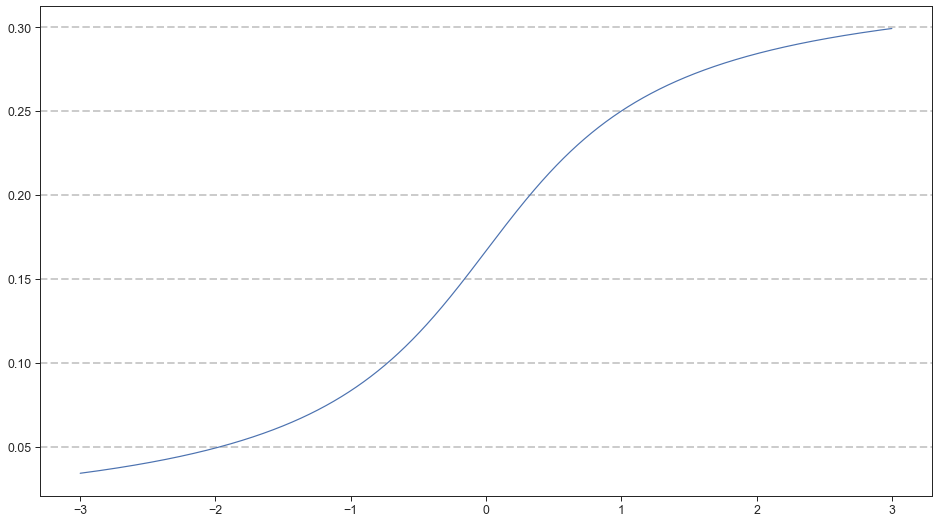

In [8]:
from scipy.integrate import quad

def f_int(x):
    return (np.arctan(x) + np.pi/2)

# Define the integration range
x_min = -3
x_max = 3

# Perform the integration to find the normalization constant c
result, _ = quad(f_int, x_min, x_max)
C_pdf = 1 / result
print("Normalization constant (c):", C_pdf)

def f_pdf(x, C=C_pdf):
    return C * (np.arctan(x) + np.pi/2)

# calculate the integral with the new constant
integral, _ = quad(f_pdf, x_min, x_max)
print("Integral of the PDF between x_min and x_max:", integral)


x_plot = np.linspace(x_min, x_max, 100000)
y_plot = f_pdf(x_plot)

fig, ax = plt.subplots()
ax.plot(x_plot, y_plot, label = 'PDF')



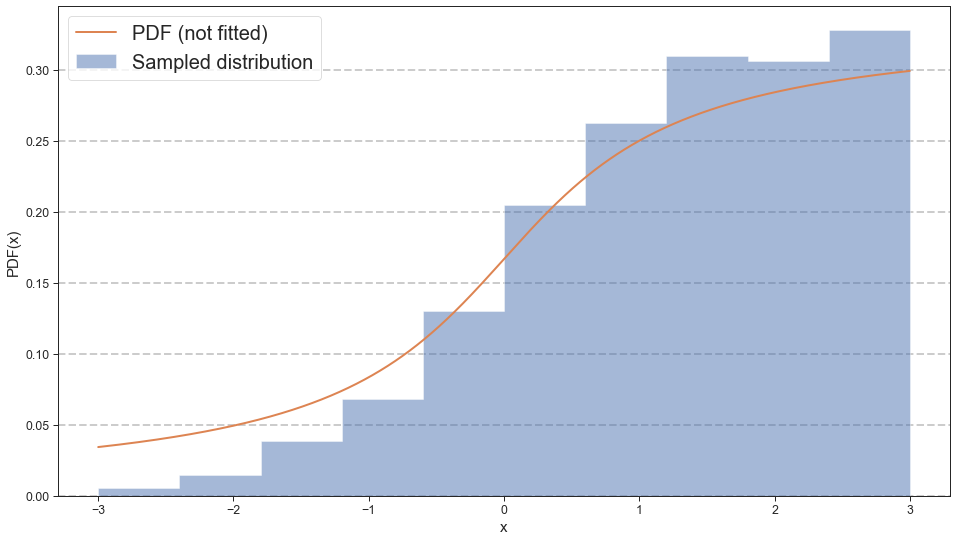

In [9]:
N_points = 100
x_range = [x_min, x_max]
y_range = [f_pdf(x_min), f_pdf(x_max)]

x_dist, ntries = ffl.acc_rej(N_points, f_pdf, [C_pdf], x_range, y_range)
Nbins = 10

fig, ax = plt.subplots()
ax.hist(x_dist, bins = Nbins, range=x_range, density = True, label = 'Sampled distribution', histtype='stepfilled', alpha=0.5);
ax.plot(x_plot, y_plot, label = 'PDF (not fitted)', linewidth = 2)
ax.set_xlabel('x', fontsize = 15)
ax.set_ylabel('PDF(x)', fontsize = 15)
ax.legend( fontsize = 20, loc='upper left')

plt.savefig('saved_images/3_2_1.png')

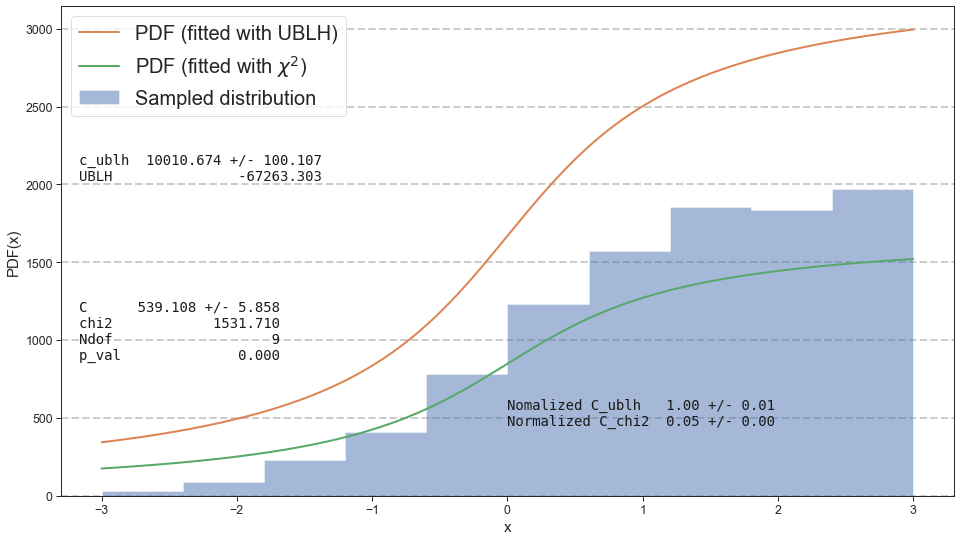

In [10]:
# Unbinned likelihood
def UBLH_func(x, c_ublh):
    return f_pdf(x, C_pdf) * c_ublh

ublh_val, ublh_dict = ffl.UBLH_minuit(UBLH_func, x_dist, [1])
y_fit = UBLH_func(x_plot, *ublh_val.values[:])
ublh_string = nice_string_output(ublh_dict, extra_spacing=2, decimals=3)

# Chi2 fit
binmids, counts, count_err = ffl.hist_for_fit(x_dist, Nbins, x_range)
chi2_val, ndof, pval, chi2_dict = ffl.fit_with_chi2(f_pdf, binmids, counts, count_err, [C_pdf])
y_fit_chi2 = f_pdf(x_plot, *chi2_val.values[:])
chi2_string = nice_string_output(chi2_dict, extra_spacing=2, decimals=3)

C_ublh = np.array([ublh_val.values[0] , ublh_val.errors[0]])
C_chi2 = np.array([chi2_val.values[0] , chi2_val.errors[0]])
norm_const = 1/np.sum(counts)
C_ublh_norm = C_ublh/N_points
C_chi2_norm = C_chi2*norm_const

Cublh = list(C_ublh_norm)
Cchi2 = list(C_chi2_norm)

C_dict = {'Nomalized C_ublh': Cublh, 'Normalized C_chi2': Cchi2}
C_string = nice_string_output(C_dict, extra_spacing=2, decimals=2)


fig, ax = plt.subplots()
add_text_to_ax(0.02, 0.7, ublh_string, ax, fontsize=14)
add_text_to_ax(0.02, 0.40, chi2_string, ax, fontsize=14)
add_text_to_ax(0.5, 0.2, C_string, ax, fontsize=14)
ax.hist(x_dist, bins = Nbins, range=x_range, label = 'Sampled distribution', histtype='stepfilled', alpha=0.5);
ax.plot(x_plot, y_fit, label = 'PDF (fitted with UBLH)', linewidth = 2)
ax.plot(x_plot, y_fit_chi2, label = 'PDF (fitted with $\chi^2$)', linewidth = 2)
ax.set_xlabel('x', fontsize = 15)
ax.set_ylabel('PDF(x)', fontsize = 15)
ax.legend( fontsize = 20, loc='upper left')


plt.savefig('saved_images/3_2_2.png')